<a href="https://colab.research.google.com/github/anuragvishwakarma/Indian-Food-image-Classifier-CNN/blob/main/Indian_Food_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d iamsouravbanerjee/indian-food-images-dataset

Dataset URL: https://www.kaggle.com/datasets/iamsouravbanerjee/indian-food-images-dataset
License(s): other
indian-food-images-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('/content/indian-food-images-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os.path
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, BatchNormalization, Dropout, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [9]:
# Image directory

image_dir = Path('/content/Indian Food Images/Indian Food Images')

In [10]:
filepath = list(image_dir.glob(r'**/*.jpg'))
label = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], filepath))

In [11]:
filepath = pd.Series(filepath, name = 'Filepath').astype(str)
label = pd.Series(label, name = 'Label')
image_df = pd.concat([filepath, label], axis = 1).sample(frac = 1.0, random_state = 1).reset_index(drop = True)
image_df.head()

,Filepath,Label
0,/content/Indian Food Images/Indian Food Images...,chapati
1,/content/Indian Food Images/Indian Food Images...,misi_roti
2,/content/Indian Food Images/Indian Food Images...,ghevar
3,/content/Indian Food Images/Indian Food Images...,lyangcha
4,/content/Indian Food Images/Indian Food Images...,sohan_papdi


In [12]:
le = LabelEncoder()
image_df['Label'] = le.fit_transform(image_df['Label'])
image_df['Label'].value_counts()

,count
Label,
67,50
59,50
6,50
29,50
4,50
...,...
50,50
77,50
68,50


In [13]:
image_df.head()

,Filepath,Label
0,/content/Indian Food Images/Indian Food Images...,18
1,/content/Indian Food Images/Indian Food Images...,54
2,/content/Indian Food Images/Indian Food Images...,34
3,/content/Indian Food Images/Indian Food Images...,50
4,/content/Indian Food Images/Indian Food Images...,77


In [14]:
image_df['Label'] = image_df['Label'].astype(str)

In [15]:
image_df.dtypes

,0
Filepath,object
Label,object


In [16]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                           validation_split = 0.2)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [17]:
train_image = train_gen.flow_from_dataframe(dataframe = image_df,
                                           x_col = 'Filepath',
                                           y_col = 'Label',
                                           target_size = (256,256),
                                           batch_size = 32,
                                           color_mode = 'rgb',
                                           class_mode = 'categorical',
                                           shuffle = True,
                                           seed = 42,
                                           subset = 'training')
val_image = train_gen.flow_from_dataframe(dataframe = image_df,
                                           x_col = 'Filepath',
                                           y_col = 'Label',
                                           target_size = (256,256),
                                           batch_size = 32,
                                           color_mode = 'rgb',
                                           class_mode = 'categorical',
                                           shuffle = True,
                                           seed = 42,
                                           subset = 'validation')
test_image = test_gen.flow_from_dataframe(dataframe = image_df,
                                           x_col = 'Filepath',
                                           y_col = 'Label',
                                           target_size = (256,256),
                                           batch_size = 32,
                                           color_mode = 'rgb',
                                           class_mode = 'categorical',
                                           shuffle = False)

Found 3200 validated image filenames belonging to 80 classes.
Found 800 validated image filenames belonging to 80 classes.
Found 4000 validated image filenames belonging to 80 classes.


In [22]:
model = Sequential()

model.add(Conv2D(16,kernel_size = (3,3), padding = 'valid', activation = 'relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add (MaxPooling2D(pool_size=(2,2), strides=2,padding = 'valid'))

model.add(Conv2D(32,kernel_size = (3,3), padding = 'valid', activation = 'relu'))
model.add(BatchNormalization())
model.add (MaxPooling2D(pool_size=(2,2), strides=2,padding = 'valid'))

model.add(Conv2D(64,kernel_size = (3,3), padding = 'valid', activation = 'relu'))
model.add(BatchNormalization())
model.add (MaxPooling2D(pool_size=(2,2), strides=2,padding = 'valid'))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 254, 254, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 125, 125, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 60, 60, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,405,281 (28.25 MB)

 Trainable params: 7,405,057 (28.25 MB)

 Non-trainable params: 224 (896.00 B)

In [24]:
model.compile(optimizer = 'adam',
             loss = 'mse',
             metrics = ['accuracy'])

In [26]:
history = model.fit(train_image,epochs=20,validation_data = val_image)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 180ms/step - accuracy: 0.9442 - loss: 0.1407 - val_accuracy: 0.9875 - val_loss: 0.0387
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.9449 - loss: 0.1359 - val_accuracy: 0.9875 - val_loss: 0.0446
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step - accuracy: 0.9582 - loss: 0.1255 - val_accuracy: 0.9875 - val_loss: 0.0440
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 203ms/step - accuracy: 0.9629 - loss: 0.0642 - val_accuracy: 0.9863 - val_loss: 0.0307
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - accuracy: 0.9677 - loss: 0.0617 - val_accuracy: 0.9875 - val_loss: 0.0415
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 204ms/step - accuracy: 0.9754 - loss: 0.0523 - val_accuracy: 0.9875 - val_loss: 0.0451
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.9704 - loss: 0.0439 - val_accuracy: 0.9875 - val_loss: 0.0600
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 177ms/step - accuracy: 0.9742 - loss: 0

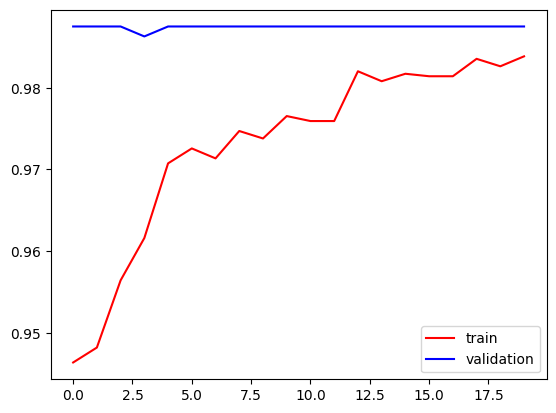

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

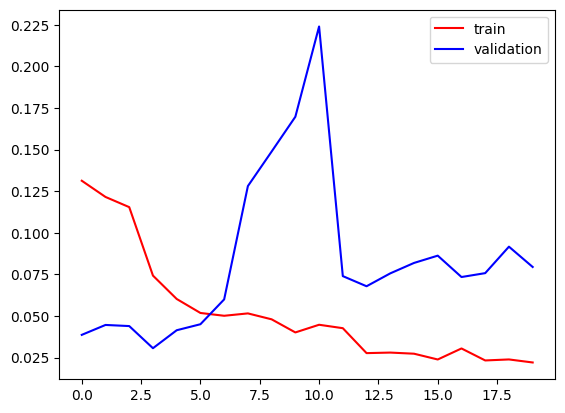

In [28]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [29]:
import cv2

In [34]:
test_img = cv2.imread('/content/004bd4d6cd.jpg')
test_img.shape

(275, 183, 3)

In [35]:
test_img = cv2.resize(test_img,(256,256))

In [36]:
test_input= test_img.reshape((1,256,256,3))

In [37]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[9.301869]], dtype=float32)